# Forest Embeddings Counterfactuals on toy causal inference data

In this Notebook, we'll walk you through usage of `ForestEmbeddingsCounterFactual` class for causal inference. We use a simple example of toy causal inference data.

In [1]:
# changing working directory
import sys
sys.path.append("../")
%matplotlib inline

## 0. Data: `make_confounded_data` from `fklearn`

Nubank's `fklearn` module provides a nice causal inference problem generator, so we're going to use the same data generating process and example from its [documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html).

In [2]:
# getting confounded data from fklearn
from fklearn.data.datasets import make_confounded_data
df_rnd, df_obs, df_cf = make_confounded_data(5000)
df_obs.head(5)

sex        age  severity  medication  recovery
0    0  33.791020  0.704547         1.0       126
1    1  24.324313  0.720286         1.0       123
2    1  38.204578  0.855910         1.0       255
3    1  35.094315  0.765145         1.0       227
4    0  21.577756  0.077813         0.0        15

We have five features: `sex`, `age`, `severity`, `medication` and `recovery`. We want to estimate the impact of `medication` on `recovery`. So, our *target* variable is `recovery`, our *treatment* variable is `medication` and the rest are our *explanatory* variables.

A good counterfactual model will tell us how would the recovery time be for each individual for both decisions of taking or not taking medication. The model should be robust to confounders, variables that impact the probability of someone taking the medication, or the effect of taking the medication. For instance, people with higher `severity` may be more likely to take the medicine. If not properly taken into account, this confounder may lead us to conclude that the medication may make recovery worse: people that took the medication may have worst recovery times (but their condition was already more severe). In the [fklearn's documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html), the data generating process is shown in detail, highlighting the confounders in the data. The effect we're looking for is $exp(-1) = 0.368$.

The `make_confounded_data` function outputs three data frames: `df_rnd`, where treatment assingment is random, `df_obs`, where treatment assingment is confounded and `df_cf`, which is the counterfactual dataframe, containing the counterfactual outcome for all the individuals.

Let us try to solve this problem using `ForestEmbeddingsCounterfactual`!

## 1. How `ForestEmbeddingsCounterfactual` works

In causal inference, we aim to answer what would happen if we made a different decision in the past. This is quite hard because we cannot make two decisions simultaneously, or go back in time and check what would happen if we did things differently. However, what we can do is observe what happened to people **who are similar to ourselves** and made different choices. We do this all the time using family members, work colleagues, and friends as references.

But what it means to be similar, and most importantly, can similarity be learned? The answer is YES! For instance, when we run a decision tree, more than solving a classification or a regression problem, we're dividing our data into clusters of similar elements given what features most explain our target. And if we repeat this process, such as building a Random Forest, we'll note that some samples are more likely to end up together in the same leaf than others. Thus, we can measure similarity by counting at how many trees in the forest two elements ended up together in the same leaf!

`ForestEmbeddingsCounterfactual` leverages the embedding created by this leaf co-occurrence similarity metric to search for similar elements on the *explanatory variables* and check how changes on the *treatment variable* reflect on changes on the *target*. If we do not have any unobserved variable, we can be confident that the treatment variable really *caused* changes on the target, since everything else will be controlled.

Let us solve `fklearn`'s causal inference problem so we can walk though the method.

## 2. Easy mode: solving `df_rnd`

We call solving `df_rnd` "easy mode" because there's no confounding, making it easy to estimate counterfactuals without paying attention to it. Nevertheless, it provides a good sanity check for `ForestEmbeddingsCounterfactual`.

### 2.1 Basic Usage

We first organize data in `X`, `W` and `y` format, needed to fit `ForestEmbeddingsCounterfactual`.

In [3]:
# organizing data into X, W and y
X = df_rnd[['sex','age','severity']]
W = df_rnd['medication']
y = df_rnd['recovery']

We then import the class and instantiate it.

In [4]:
# importing cfml-tools
from cfml_tools import ForestEmbeddingsCounterfactual
fecf = ForestEmbeddingsCounterfactual()

C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


I advise that you read the docstring to know about the parameters and make the tutorial easier to follow!

Before fitting and getting counterfactuals, a good sanity check is doing 5-fold CV, to test the generalization power of the underlying forest model:

In [5]:
# validating model using 5-fold CV
cv_scores = fecf.get_cross_val_scores(X, y)
print(cv_scores)

[0.55620144 0.52712799 0.52457062 0.54054325 0.55306407]


Here, we have R2 scores in the range of ~0.55, which seem reasonable (no overfitting). However, there's actually no baseline here: you just need to be confident that the model can capture and generalize relationships between explanatory variables and treatment assignments and effects. Nevertheless, here are some tips: If your CV metric is too high (R2 very close to 1.00, for instance), it may mean that the treatment variable has no effect on the outcomes, or its effect is "masked" by correlated proxies in the explanatory variables. If your CV metric is too low (e.g. R2 close to 0), it does not mean that the model isn't useful: the outcome may be explained only by the treatment variable. In this case, since the underlying model is a `ExtraTreesRegressor` the forest embedding would work as a unsupervised embedding, like `sklearn`'s `RandomTreesEmbedding`.

We proceed to fit the model using `X`, `W` and `y`.

In [6]:
# fitting data to our model
fecf.fit(X, W, y)

Calling `.fit()` builds the forest and creates a nearest neighbor index using leaf co-ocurrence as a similarity metric. For more details on that, check my [earlier post](https://gdmarmerola.github.io/umap-supervised-embeddings) about forest embeddings.

We then predict the counterfactuals all our individuals. By calling `.predict()`, we get the dataframe in the `counterfactuals` variable, which stores predictions for both `W = 0` and `W = 1`. The counterfactuals are obtained by querying the nearest neighbor index built on `.fit()` for `n_neighbors` and calculating the average outcome given different values of `W`.

In [7]:
# let us predict counterfactuals for these guys
counterfactuals = fecf.predict(X)
counterfactuals.head()

y_hat            
W           0           1
id                       
0   42.664100  113.148495
1   51.885795  145.991149
2   89.304629  244.563599
3   74.818696  201.136780
4   15.338583   41.773932

Then, we can compute treatment effects as follows:

In [8]:
# treatment effects
treatment_effects = counterfactuals['y_hat'][0]/counterfactuals['y_hat'][1]

And compare estimated effects vs real effects:

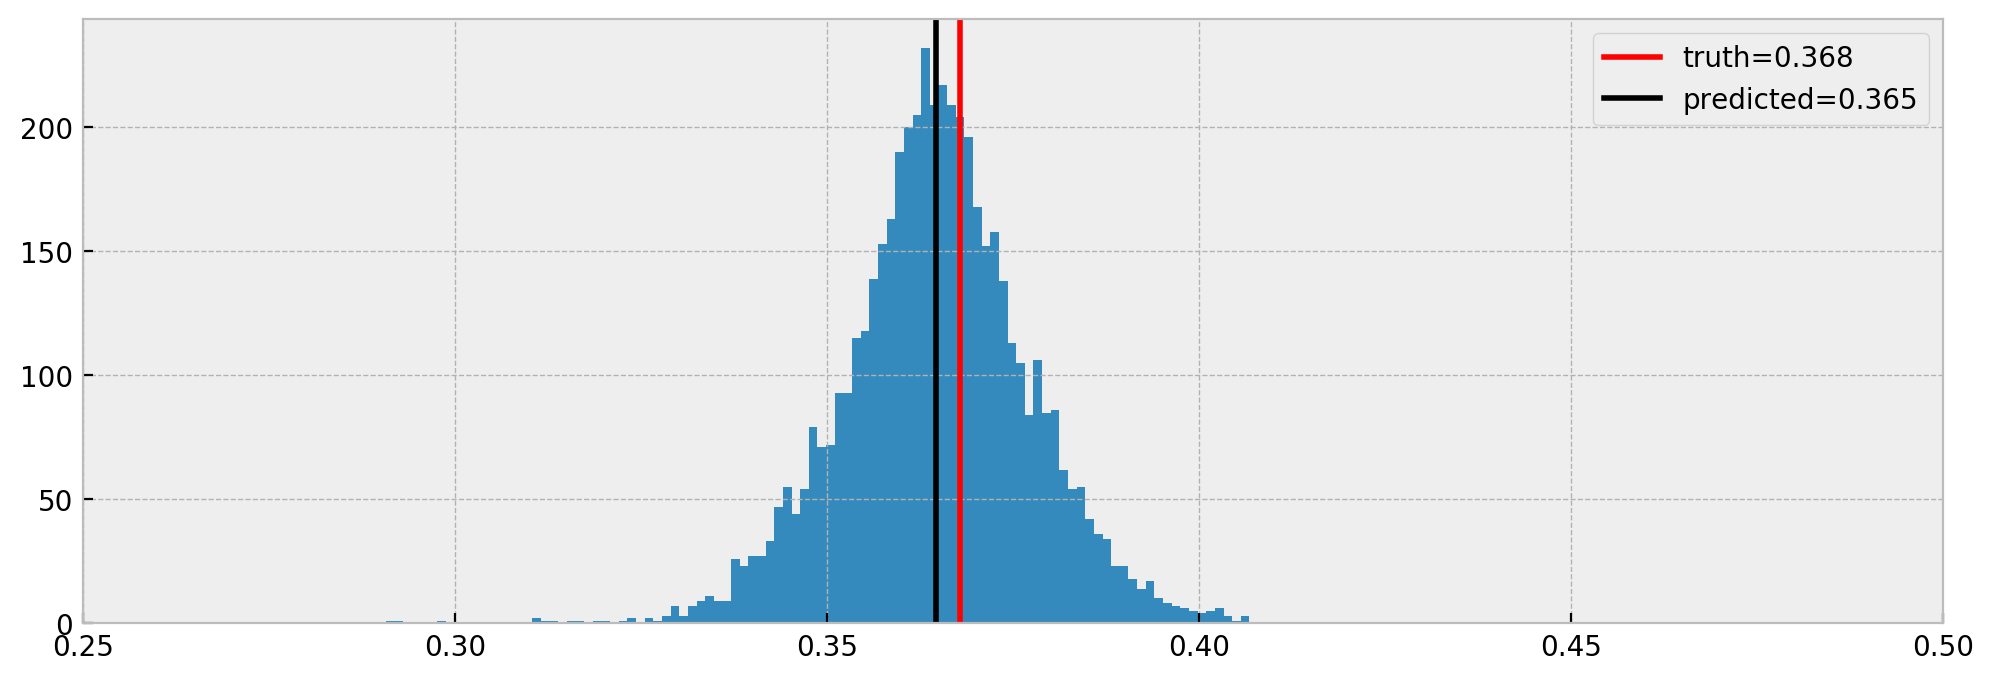

In [9]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=100);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

Cool! As we can see, the model nicely estimated the true effect. 

But how can we be sure that the model is performing well? Let us do a quick diagnostic using a visualization of our forest embedding.

### 2.2 Diagnostic and criticism 

A good diagnostic is to look at a 2D representation of our forest embedding, using UMAP:

In [10]:
# getting embedding from data
reduced_embed = fecf.get_umap_embedding(X)

C:\Users\Guilherme\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Under the hood, UMAP takes our leaf-based similarity metric and creates a 2D representation that tries to preserve it. This shows *natural clusters* in our data, and surfaces what the model learned in terms of similarity and representation. 

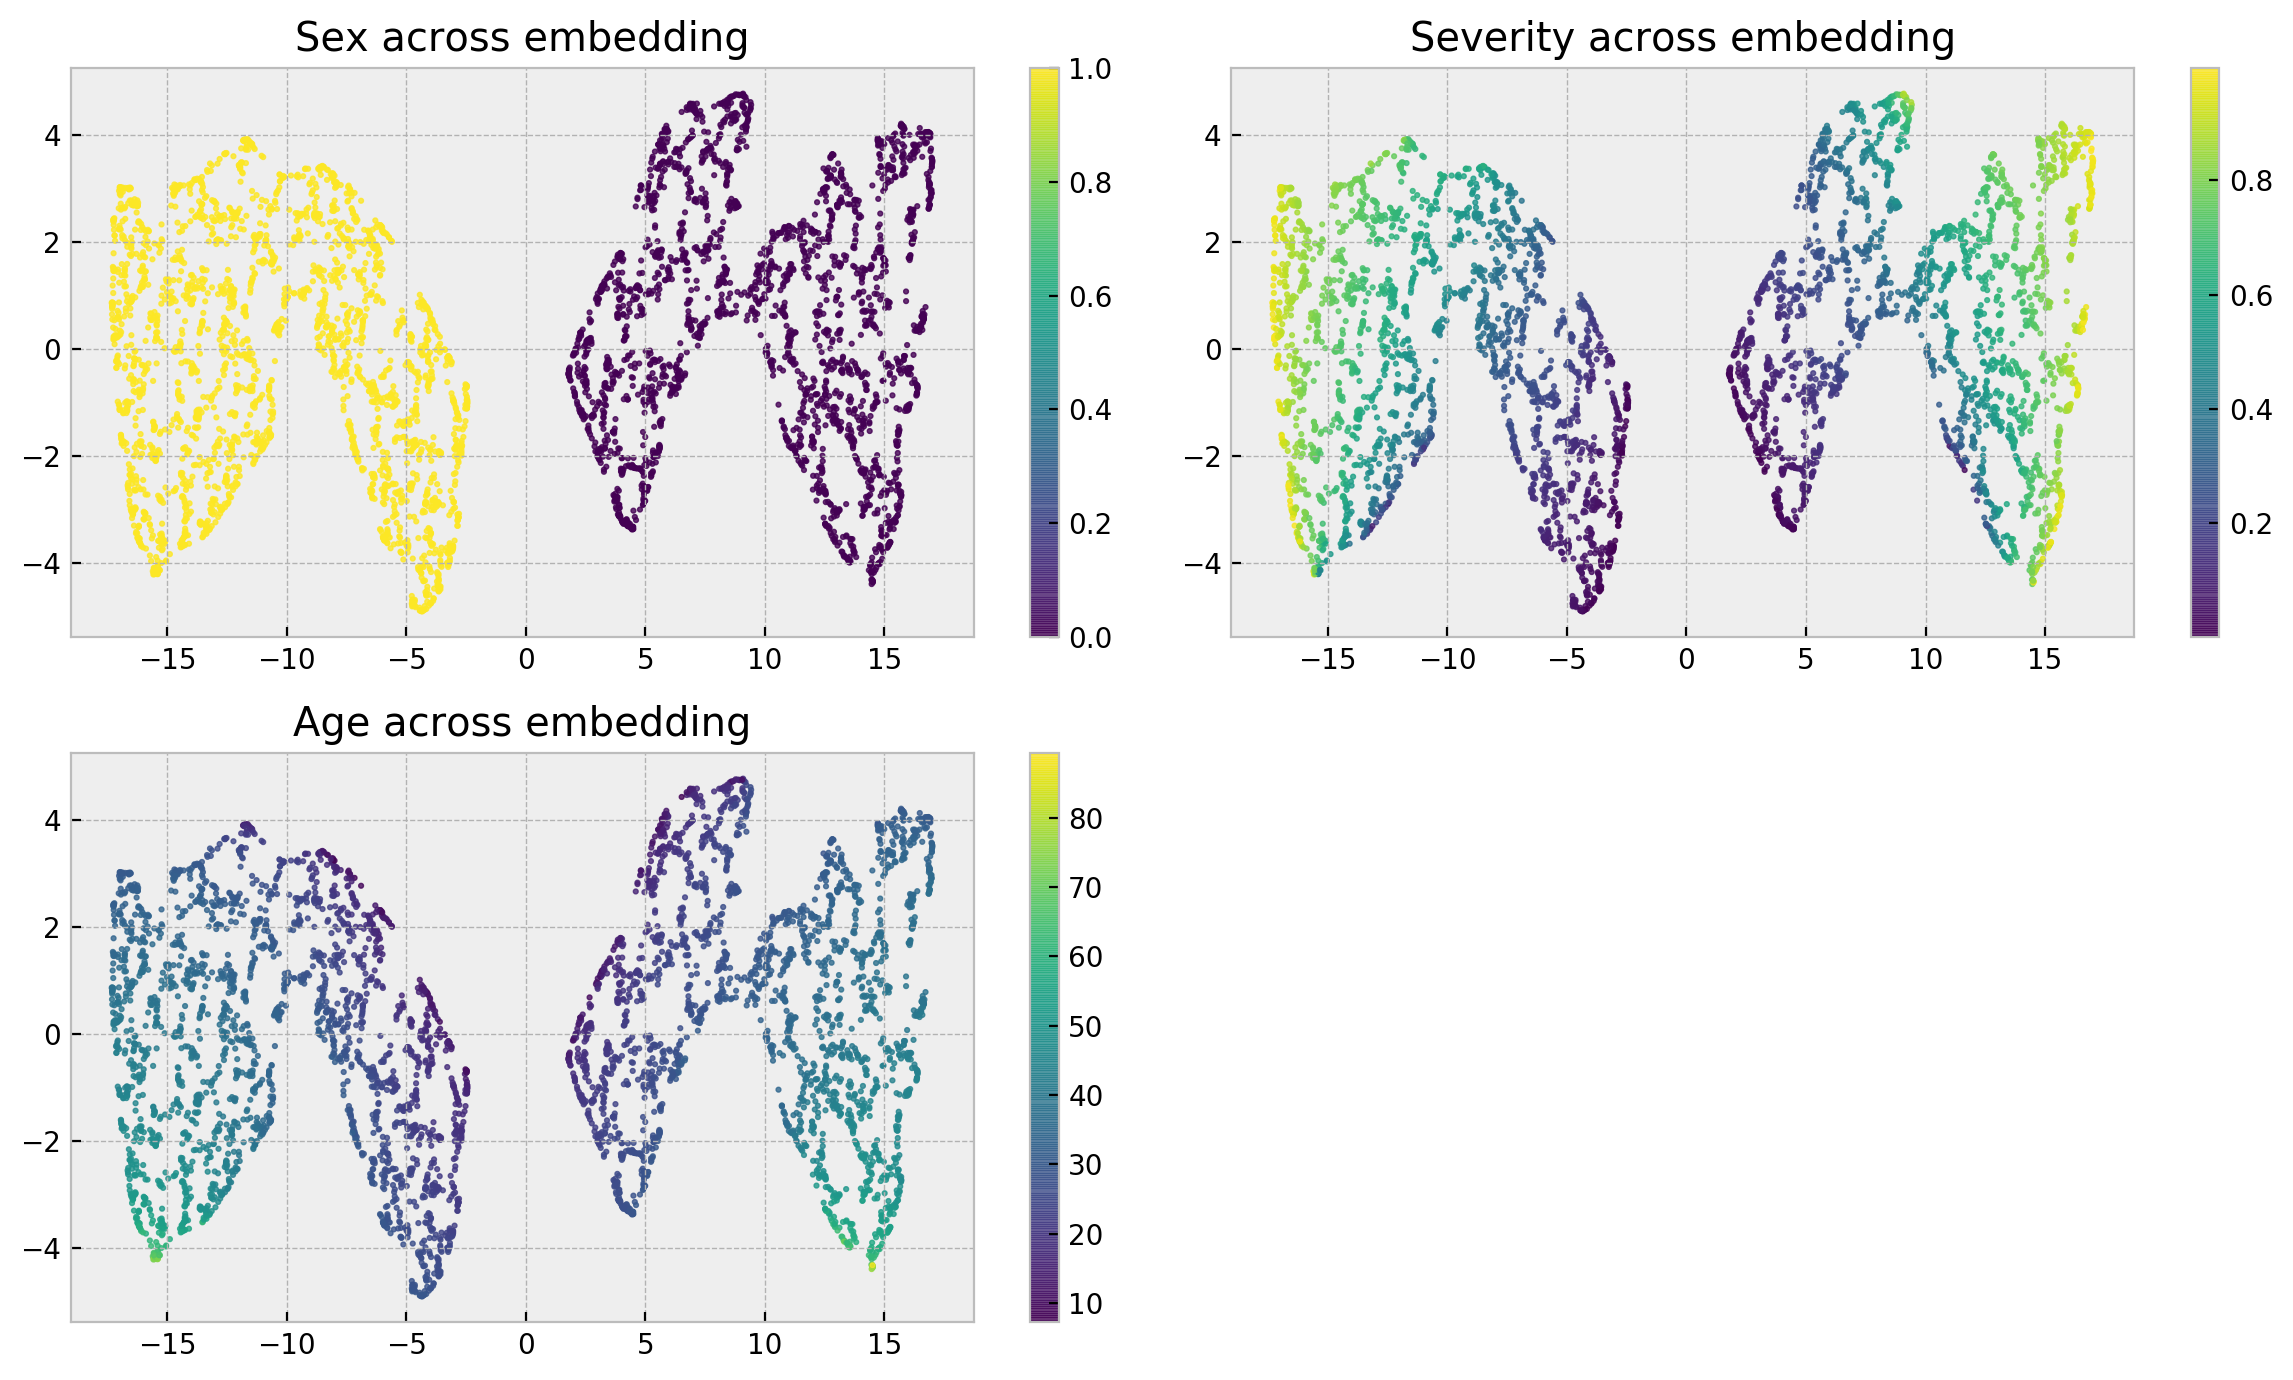

In [11]:
# plotting embedding
plt.style.use('bmh')
plt.figure(figsize=(12,7), dpi=200)

# first plot for sex
plt.subplot(2, 2, 1)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['sex'])
plt.title('Sex across embedding')
plt.colorbar()

# second plot for severity
plt.subplot(2, 2, 2)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['severity'])
plt.title('Severity across embedding')
plt.colorbar()

# third plot for age
plt.subplot(2, 2, 3)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['age'])
plt.title('Age across embedding')
plt.colorbar()


# plot properties
plt.tight_layout()
plt.show()

The plots show how our explanatory variables are distributed across the embedding. `Sex` breaks the embedding into two separate clusters, while `severity` is distributed in a left-right gradient inside each cluster and `age` follows an up-down gradient. The gradients are smooth enough such that we can be confident that at each local neighborhood individuals are very similar. Thus, the only thing that could explain differences in the outcomes of members of a local neighborhood is dispersion in the treatment variable!

Let us have a look at the outcomes and treatment assignments:

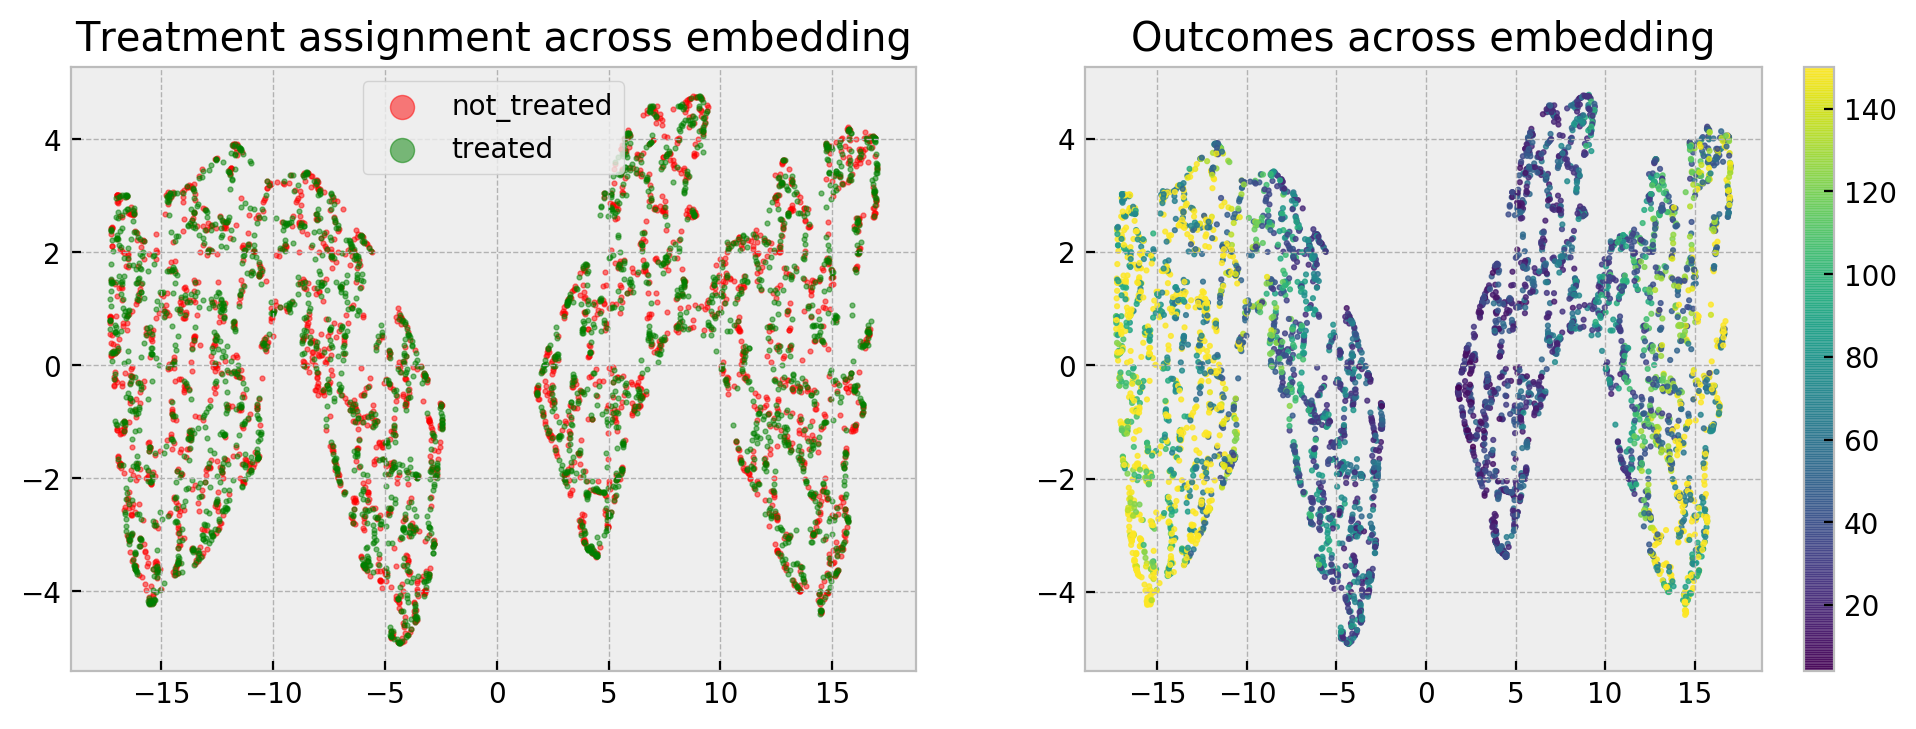

In [12]:
# plotting embedding
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)

# first plot for treatment assignment
plt.subplot(1, 2, 1)
plt.scatter(reduced_embed[W==0,0], reduced_embed[W==0,1], label='not_treated', alpha=0.5, s=3, c='red')
plt.scatter(reduced_embed[W==1,0], reduced_embed[W==1,1], label='treated', alpha=0.5, s=3, c='green')
plt.title('Treatment assignment across embedding')
plt.legend(markerscale=5)

# second plot for outcome
plt.subplot(1, 2, 2)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, vmax=150, s=3, c=y)
plt.title('Outcomes across embedding')
plt.colorbar()
plt.show()

As we can see, treated and not treated individuals are uniformly scattered across the map, and the granular pattern in the right-hand side plot tells us that lack of treatment degrades outcomes for all local neighborhoods. That's how we compute counterfactuals: comparing how the treatment variable impacts outcomes for similar individuals! 

Cool, right? The uniform assignment case is good to get the intuition about embeddings and usage of `ForestEmbeddingsCounterfactual`. Let us move to the case where treatment assignments are not uniformly distributed, making the counterfactual estimation harder (but still doable!).

## 3. Hard mode: solving `df_obs`

Now, we go for the "hard mode" and try to solve `df_obs`. Now we have confounding, which means that treatment assingment will not be uniform. Nevertheless, we run `ForestEmbeddingsCounterfactual` like before!

### 3.1 Basic Usage

Organizing data in `X`, `W` and `y` format again:

In [13]:
# organizing data into X, W and y
X = df_obs[['sex','age','severity']]
W = df_obs['medication']
y = df_obs['recovery']

Validating the model, as before:

In [14]:
# importing cfml-tools
from cfml_tools import ForestEmbeddingsCounterfactual
fecf = ForestEmbeddingsCounterfactual()

In [15]:
# validating model using 5-fold CV
cv_scores = fecf.get_cross_val_scores(X, y)
print(cv_scores)

[0.94675757 0.92104049 0.95596916 0.93747454 0.92219758]


Here it gets a little bit different. Remember that a high R2 could mean that the treatment variable has little effect on the outcome? As the treatment assignment is correlated with the other variables, they "steal" importance from the treatment and our R2 gets higher in the confounded case. This will become even clearer when we look at the UMAP embedding.

We proceed to fit the model using `X`, `W` and `y`.

In [16]:
# fitting data to our model
fecf.fit(X, W, y)

We then predict the counterfactuals for all our individuals. 

In this case, we can see some NaNs. That's because some individuals do not have enough treated or untreated neighbors to  estimate the counterfactuals, controlled by the parameter `min_sample_effect`. When this parameter is high, we are conservative, getting more NaNs but less variance in counterfactual estimation.

In [17]:
# let us predict counterfactuals for these guys
counterfactuals = fecf.predict(X)
counterfactuals.head()

y_hat            
W         0.0         1.0
id                       
0   42.371148  115.267816
1         NaN  142.694218
2         NaN  240.070425
3         NaN  204.021652
4   15.107347         NaN

Comparing true effect with estimated:

C:\Users\Guilherme\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Guilherme\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


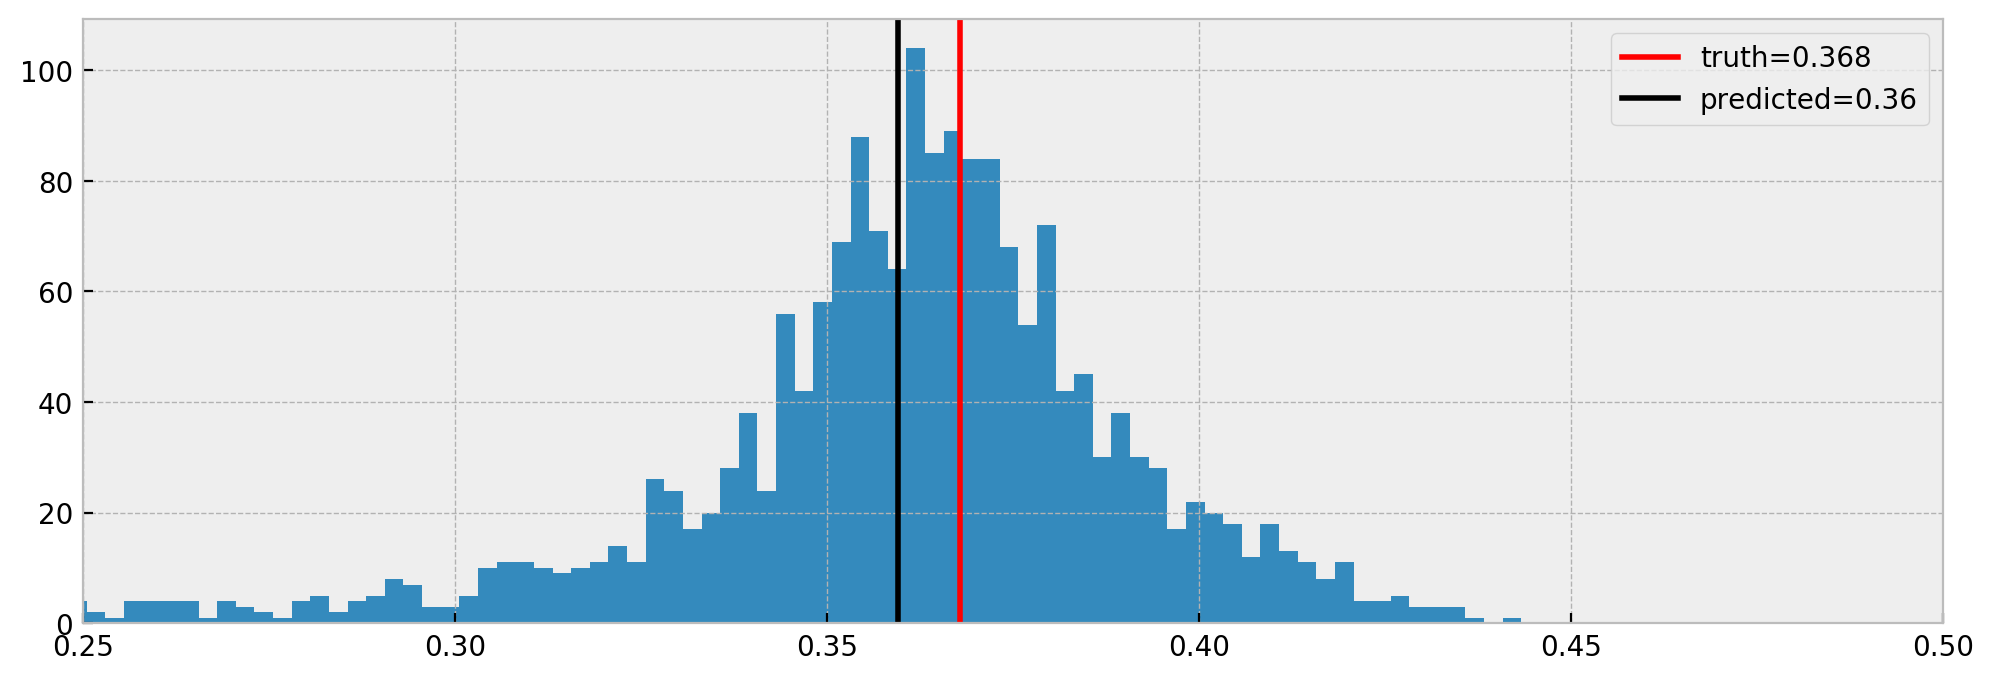

In [18]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][0]/counterfactuals['y_hat'][1]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=100);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

Nice! The model estimated the effect very well again. Note that we have less samples in the histogram, due to NaNs. Nevertheless, it is a cool result and shows that `ForestEmbeddingsCounterfactual` can work with confounded data.

### 3.2 Diagnosis and criticism

Now things get interesting. Let us check how our 2D embedding changes with the confounding effect: 

In [19]:
# getting embedding from data
reduced_embed = fecf.get_umap_embedding(X)

C:\Users\Guilherme\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


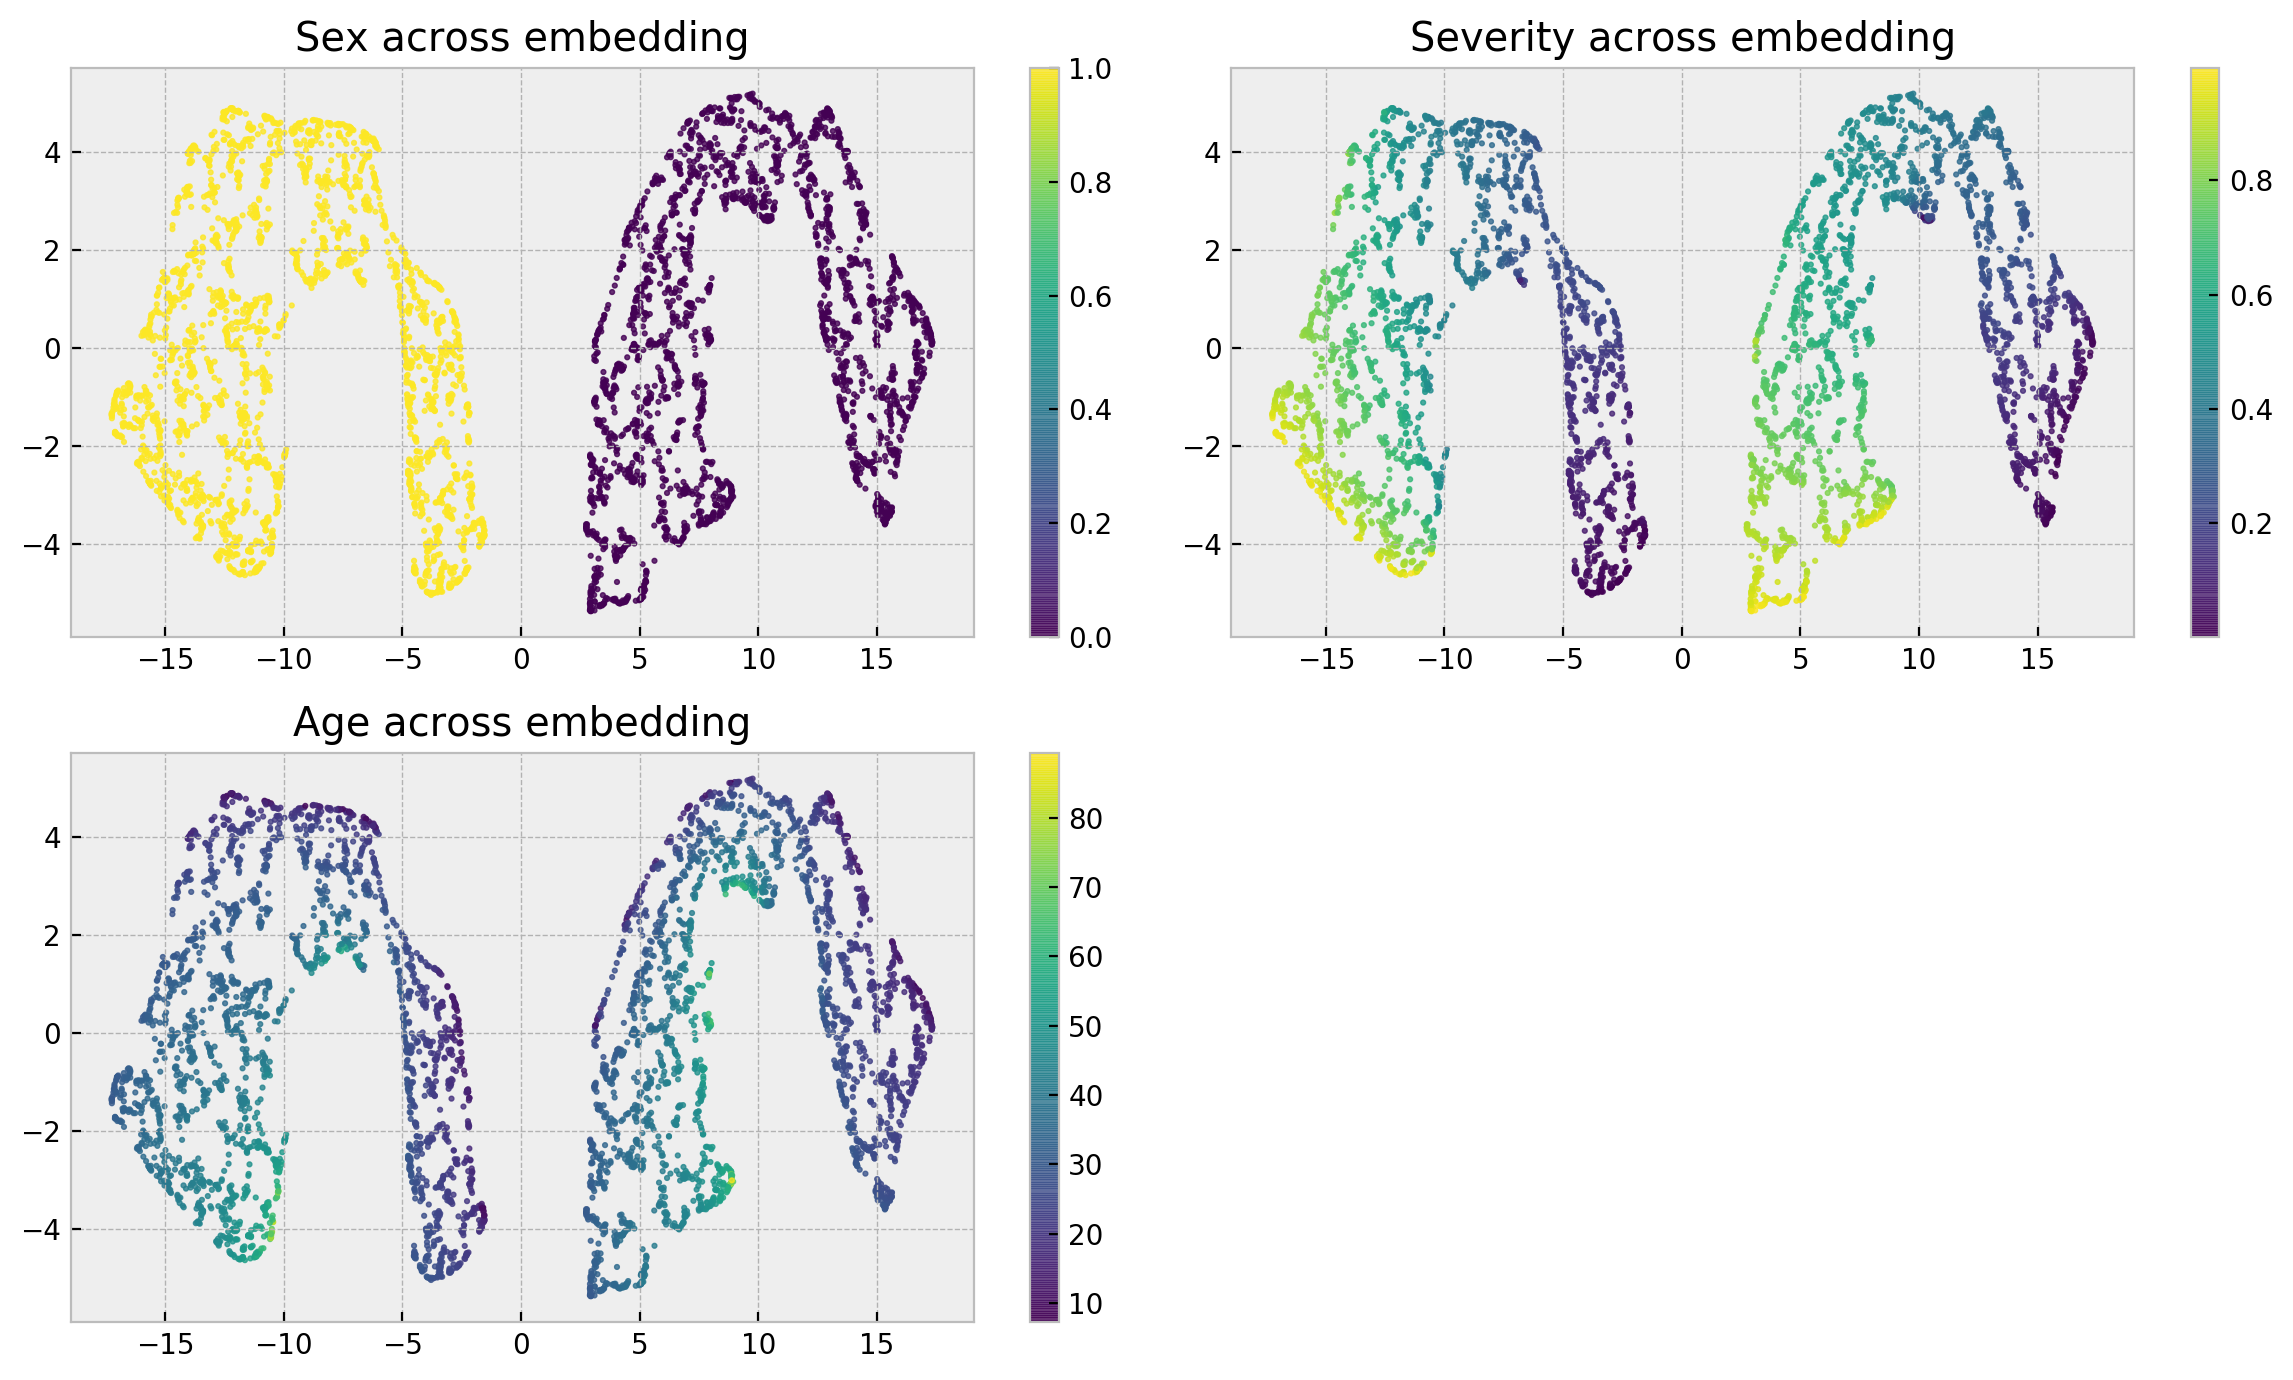

In [20]:
# plotting embedding
plt.style.use('bmh')
plt.figure(figsize=(12,7), dpi=200)

# first plot for sex
plt.subplot(2, 2, 1)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['sex'])
plt.title('Sex across embedding')
plt.colorbar()

# second plot for severity
plt.subplot(2, 2, 2)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['severity'])
plt.title('Severity across embedding')
plt.colorbar()

# third plot for age
plt.subplot(2, 2, 3)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, s=3, c=X['age'])
plt.title('Age across embedding')
plt.colorbar()

# plot properties
plt.tight_layout()
plt.show()

The distribution of explanatory variables across the embedding gets a little bit different. `Sex` still breaks the embedding into two separate clusters, but `severity` is now distributed in a up-down gradient inside each cluster and `age` follows a left-right gradient. The gradients are still smooth enough such that we can be confident that at each local neighborhood individuals are very similar. 

Let us have a look at the outcomes and treatment assignments:

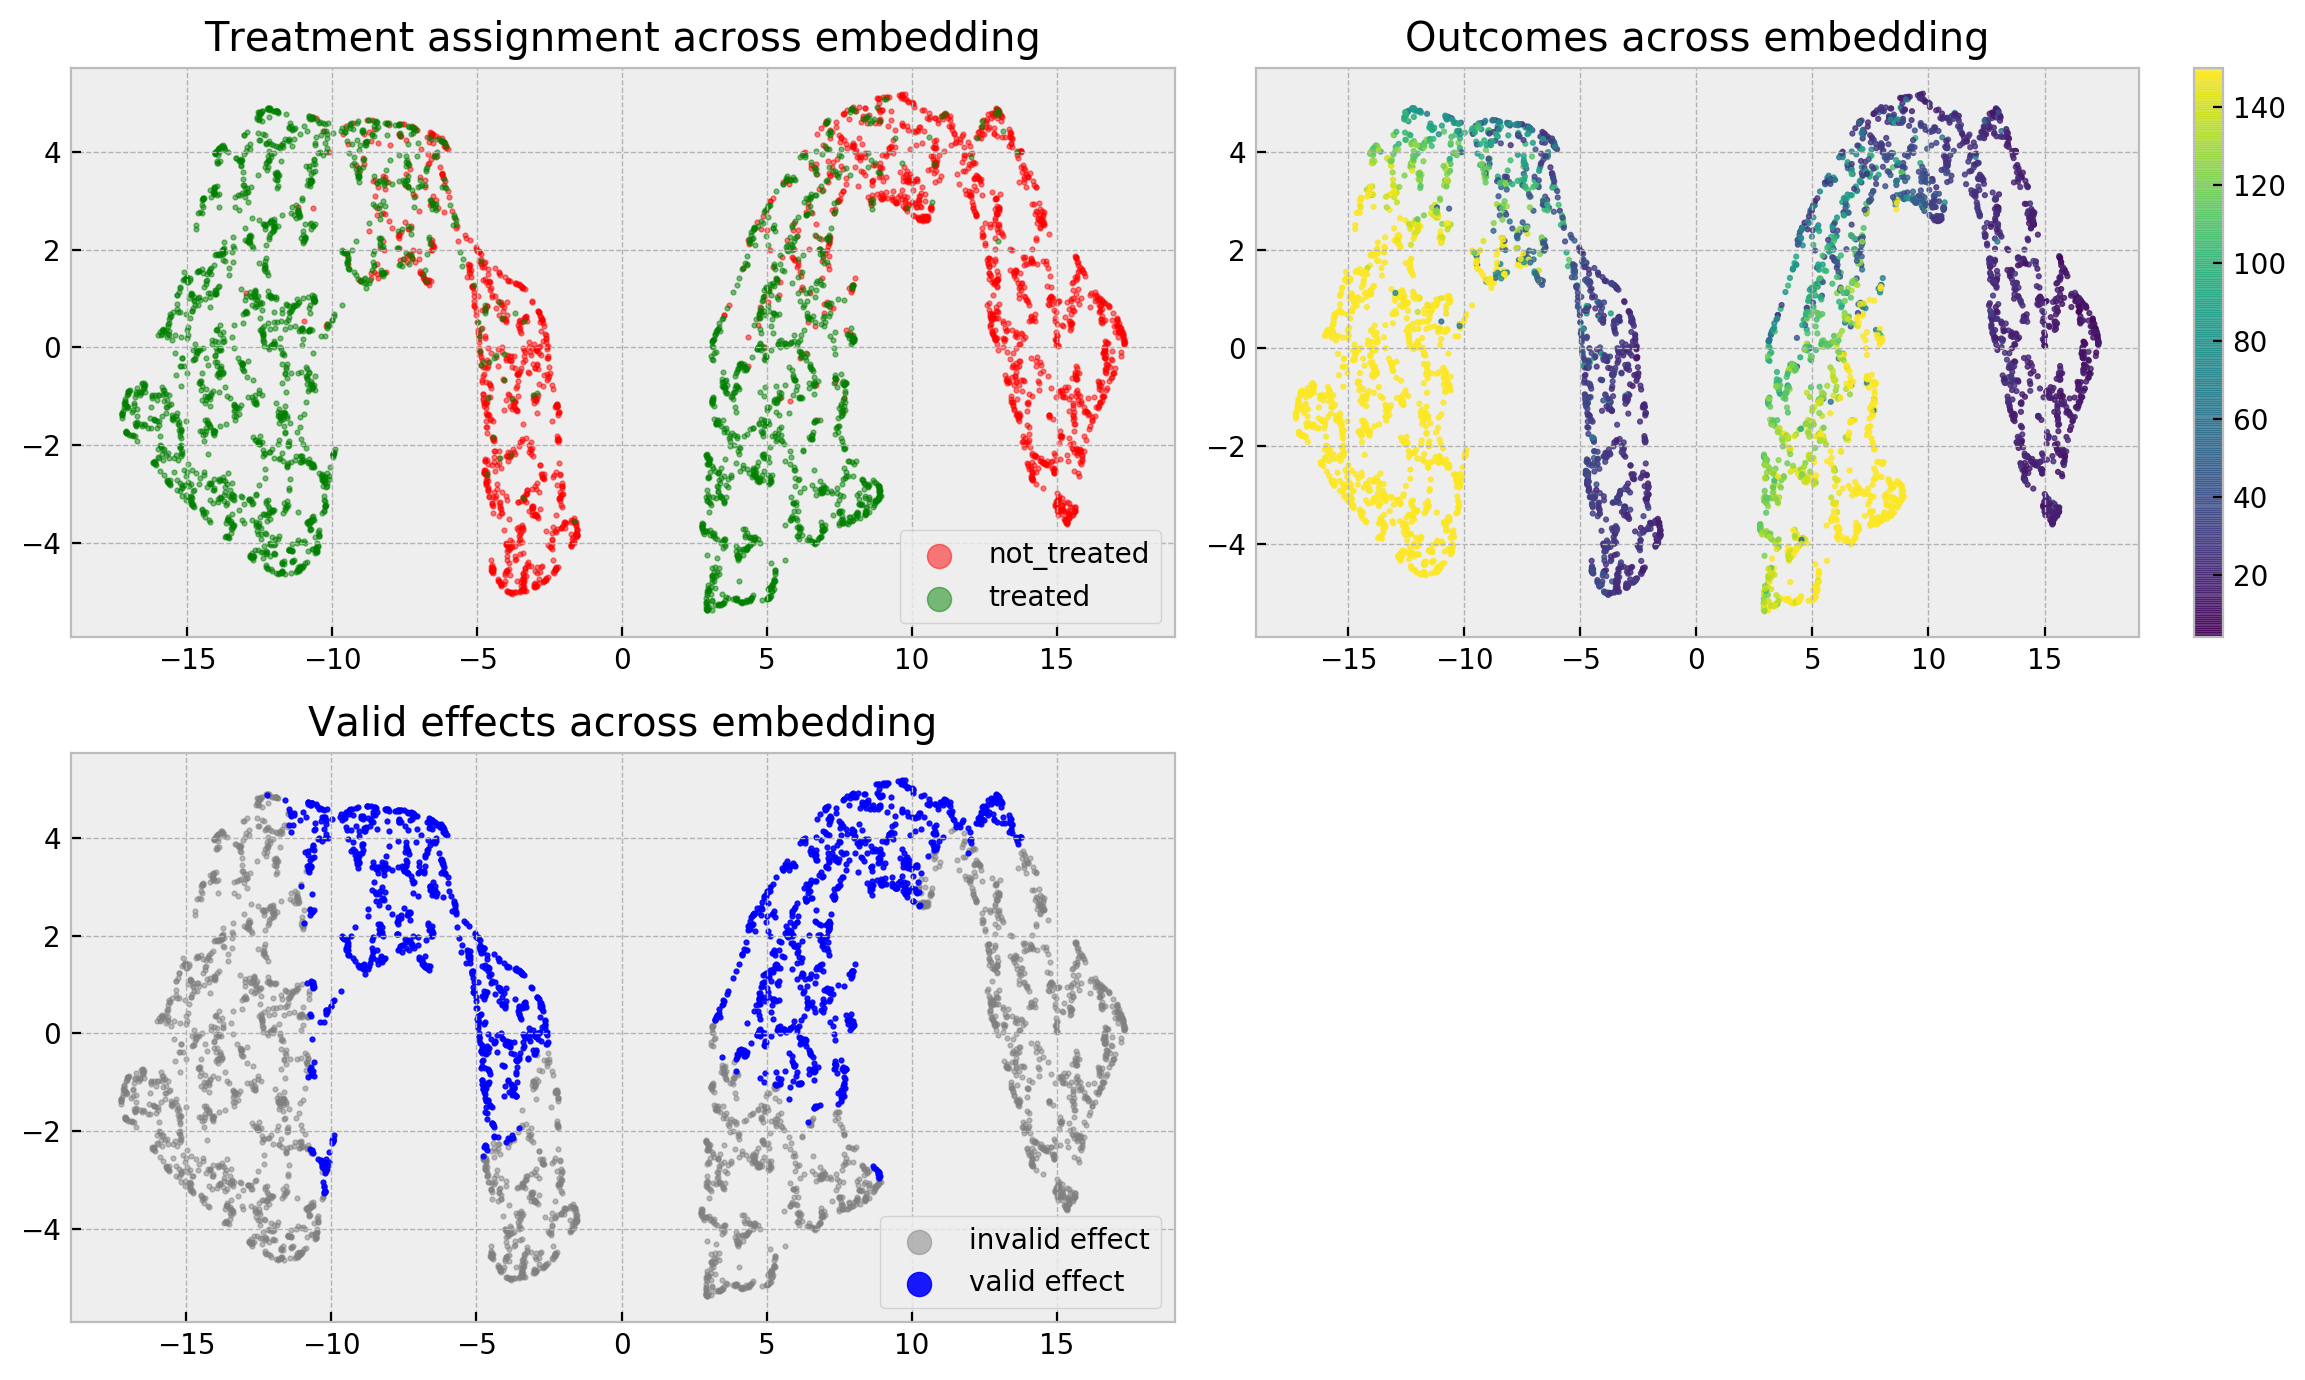

In [21]:
# plotting embedding
plt.style.use('bmh')
plt.figure(figsize=(12,7), dpi=200)

# first plot for treatment assignment
plt.subplot(2, 2, 1)
plt.scatter(reduced_embed[W==0,0], reduced_embed[W==0,1], label='not_treated', alpha=0.5, s=3, c='red')
plt.scatter(reduced_embed[W==1,0], reduced_embed[W==1,1], label='treated', alpha=0.5, s=3, c='green')
plt.title('Treatment assignment across embedding')
plt.legend(markerscale=5)

# second plot for outcome
plt.subplot(2, 2, 2)
plt.scatter(reduced_embed[:,0], reduced_embed[:,1], alpha=0.8, vmax=150, s=3, c=y)
plt.title('Outcomes across embedding')
plt.colorbar()

# third plot for outcome
plt.subplot(2, 2, 3)
is_null = counterfactuals.isnull().sum(axis=1).astype(bool)
plt.scatter(reduced_embed[is_null,0], reduced_embed[is_null,1], alpha=0.5, vmax=150, s=3, c='grey', label='invalid effect')
plt.scatter(reduced_embed[~is_null,0], reduced_embed[~is_null,1], alpha=0.9, vmax=150, s=3, c='blue', label='valid effect')
plt.title('Valid effects across embedding')
plt.legend(markerscale=5)

plt.tight_layout()
plt.show()

All our analyses get very clear at this point. At the upper left-hand side, we can see that except for a small region at the center of our clusters, there's no mix of treated and untreated individuals. This lack of mixing makes difficult to estimate counterfactuals, as there's no similar individuals with different treatment assigments. This makes a lot of the effects invalid, as we see in the lower left-hand side. However, the lack of mixing also made the outcomes more predictable, as we can see in the right-hand side (the embedding is very homogenoeous with respect to the outcome). 

If you backtrack a little bit, you'll notice that we can only predict counterfactuals for people of average severity! That's why I really like using embeddings for explaining models: they are a quick and visual diagnosis of what your model learned, and can be used to extract knowledge from it for a lot of purposes including causal inference.

I hope you liked the tutorial and will use `cfml_tools` for your causal inference problems soon!